In [1]:
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from cdft.dft3d import dft_core
from cdft.lj_eos import lj_eos

torch.set_default_dtype(torch.float64)
device = torch.device('cuda')

In [2]:
sigma = 3.73
epsilon = 148.0
parameters = {'sigma':sigma, 'epsilon':epsilon}

In [3]:
structure = Structure.from_file('structures/IRMOF-1.cif')
print('formula:        ', structure.formula)
print('num_sites:      ', structure.num_sites)
print('lattice_lengths:', structure.lattice.lengths)

formula:         Zn32 H96 C192 O104
num_sites:       424
lattice_lengths: (25.832, 25.832, 25.832)


/home/lucas/miniforge3/envs/torch/lib/python3.13/site-packages/pymatgen/io/cif.py:1290: UserWarning: Issues encountered while parsing CIF: Skipping relative stoichiometry check because CIF does not contain formula keys.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [4]:
T = 125.0
system_size = np.array([l for l in structure.lattice.lengths])
points = np.array([64, 64, 64])
dft = dft_core(parameters=parameters, temperature=T, system_size=system_size, angles=None, points=points, device=device)
dft.cell_size

array([0.403625, 0.403625, 0.403625])

In [5]:
forcefield = pd.DataFrame()
forcefield['type'] = ['C','H','O','Zn']
forcefield['sigma'] = np.array([3.47299, 2.84642, 3.03315, 2.4615])
forcefield['epsilon'] = np.array([47.8562, 7.64893, 48.1581, 62.3992])

def lj_potential(r,sigma,epsilon):
    return 4.0*epsilon*((sigma/r)**12-(sigma/r)**6) 

rc = 12.0

Vext = torch.zeros_like(dft.X)
U = torch.zeros_like(dft.X)
for k, site in enumerate(structure):
    sigmas = float(forcefield['sigma'][forcefield['type']==site.species_string].values[0])
    epsilons = float(forcefield['epsilon'][forcefield['type']==site.species_string].values[0])
    sigmasf = 0.5*(sigma+sigmas) 
    epsilonsf = np.sqrt(epsilon*epsilons)
    rx = dft.X-structure.cart_coords[k,0] 
    ry = dft.Y-structure.cart_coords[k,1] 
    rz = dft.Z-structure.cart_coords[k,2] 
    rx -= system_size[0]*(rx/system_size[0]).round()
    ry -= system_size[1]*(ry/system_size[1]).round()
    rz -= system_size[2]*(rz/system_size[2]).round()
    r = torch.sqrt(rx**2+ry**2+rz**2)
    U = lj_potential(r,sigmasf,epsilonsf)
    U[r==0] = np.inf
    U[r>rc] = 0.0
    Vext += U

Text(0, 0.5, '$y$ (\\AA{})')

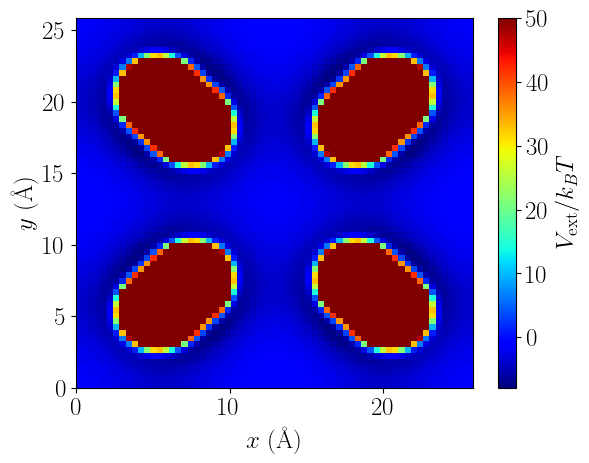

In [6]:
plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
# 'axes.linewidth':1.1, 
'lines.linewidth':1.6,
'legend.fontsize': 18,
'legend.frameon':False
#'figure.figsize':(7.9, 6.1)
})


plt.figure()
c=plt.pcolormesh(dft.X[:,:,points[0]//2].cpu(),dft.Y[:,:,points[1]//2].cpu(),Vext[:,:,points[2]//2].cpu()/T,vmax=50.0,cmap='jet')
plt.colorbar(label=r'$V_{\mathrm{ext}}/k_B T$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')

In [7]:
# P0 = 0.013801e6
P0 = 0.26876e6
P = torch.hstack((torch.arange(1e0,1e1,1e0),torch.arange(1e1,1e2,1e1), torch.arange(1e2,1e3,1e2), 
                  torch.arange(1e3,1e4,1e3),torch.arange(1e4,1e5,1e4), torch.arange(1e5,2e5,1e5)))
bulk_density = torch.empty_like(P)

eos = lj_eos(parameters, T)
bulk_density[0] = eos.density(P[0],'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],bulk_density[i-1])

In [ ]:
dft.initial_condition(bulk_density[0],Vext,model='ideal')

Nads = torch.zeros(len(P))
for i in range(len(P)):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='fire',
                                    alpha0=0.2,dt=0.02,tol=1e-8,max_it=1001,logoutput=False)
    Nads[i] = dft.total_molecules
    print(dft.it,dft.error.numpy(),P[i].numpy()*1e-5,Nads[i].numpy())
    if torch.isnan(dft.error) or dft.it > 1000: break
    else:
        torch.save(dft.rho.cpu(), f'rho.pt')
        torch.save((P,Nads), f'adsorption.pt')

90 9.834312305145026e-09 1e-05 0.010618195887473751
146 2.235637459396129e-09 2e-05 0.021241563462357775
146 1.5072795114770092e-09 3.0000000000000004e-05 0.031870106195482854
146 1.2172823064664307e-09 4e-05 0.04250382744334671
146 1.063270034554137e-09 5e-05 0.05314273057481886
146 9.693566224504319e-10 6.000000000000001e-05 0.0637868189648805
146 9.072335503874512e-10 7.000000000000001e-05 0.07443609599297611
146 8.638904229150123e-10 8e-05 0.08509056504261527
146 8.325169669520953e-10 9e-05 0.09575022950149664
146 8.091850203551159e-10 0.0001 0.10641509276127019
172 6.916626058426999e-09 0.0002 0.213350406553786
146 8.882554113549036e-09 0.00030000000000000003 0.32080936772367263
146 8.212303545341303e-09 0.0004 0.4287954235113167
146 7.618320641794959e-09 0.0005 0.5373120757641879
128 9.812199257910262e-09 0.0006000000000000001 0.6463628526543167
142 9.811481957769587e-09 0.0007000000000000001 0.7559513485747532
144 8.671077749655477e-09 0.0008 0.8660811727684701
145 6.29717023220

In [ ]:
dft.rho = torch.load(f'rho.pt').to(device)
P, Nads = torch.load(f'adsorption.pt')
last = i

In [ ]:
for i in range(last,len(P)):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='fire',
                                    alpha0=0.2,dt=0.02,tol=1e-8,max_it=2001,logoutput=True)
    Nads[i] = dft.total_molecules
    print(dft.it,dft.error.numpy(),P[i].numpy()/P0,Nads[i].numpy())
    if torch.isnan(dft.error) or dft.it > 2000: break
    else:
        torch.save(dft.rho.cpu(), f'rho.pt')
        torch.save((P,Nads), f'adsorption.pt')

In [ ]:
import seaborn as sns

colors = sns.color_palette("mako")

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif',  
#'figure.figsize':(7.9, 6.1)
})

plt.plot(1e-5*P, Nads, '-', color=colors[3], linewidth=2.0, label='cDFT')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'$N$ (molecules/u.c.)', fontsize=18)
# plt.xlim([0.0,100.])
# plt.ylim([None,0.004])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=8, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')
# plt.savefig('figures/isotherm_methane.pdf', bbox_inches='tight')

In [ ]:
plt.figure()
c=plt.pcolormesh(dft.X[:,:,points[0]//2].cpu(),dft.Y[:,:,points[1]//2].cpu(),dft.rho[:,:,points[2]//2].cpu()/dft.rhob.cpu(),cmap='jet',shading='gouraud')
plt.colorbar(c, label=r'$\rho(x,y)/ \rho_b$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')